<a href="https://colab.research.google.com/github/DavidDaimond/ds_school_2020/blob/master/task%203/3_Strokatov_Home_Work_Reworked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.misc import derivative
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data preparations**

In [0]:
dfm = pd.read_csv('./tmdb_5000_movies.csv')


dfm['release_date'] = pd.to_datetime(dfm['release_date'])
dfm['year'] = pd.DatetimeIndex(dfm['release_date']).year
dfm['month'] = pd.DatetimeIndex(dfm['release_date']).month
dfm['weekday'] = dfm['release_date'].dt.dayofweek


dfm.original_language[dfm.original_language != 'en'] = 0
dfm.original_language[dfm.original_language != 0] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
import json

#Translate data to acceptable format by converting a JSON columns
prime_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 0, 'name': 'None'}))
secondary_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[1] if (len(x) > 1) else {'id': 0, 'name': 'None'}))

#genres
dfm['prime_genre_name'] = prime_genre['name']
dfm['secondary_genre_name'] = secondary_genre['name']

#production country
dfm['production_country_id'] = pd.json_normalize(dfm.production_countries.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'iso_3166_1': 'None', 'name': 'Unknown'}))['iso_3166_1']

#production companies
dfm['production_company_name'] = pd.json_normalize(dfm.production_companies.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 'None', 'name': 'NaN'}))['name']

In [0]:
#New company and genre columns
dfm['company_portfolio'] = dfm.groupby('production_company_name')['production_company_name'].transform('count')
dfm.production_company_name[dfm.company_portfolio < 2] = 'Noname company'
dfm['genre_popularity'] = dfm.groupby('prime_genre_name')['prime_genre_name'].transform('count') + dfm.groupby('secondary_genre_name')['secondary_genre_name'].transform('count')


dfm['profitable'] = (dfm.revenue / dfm.budget) > 2.5
dfm['foreign'] = (dfm.production_country_id) != 'US'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


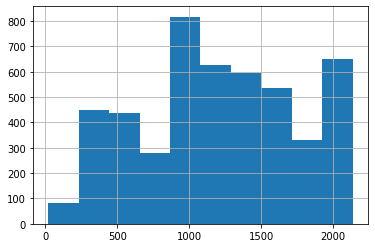

In [0]:
dfm.genre_popularity.hist()

In [0]:
dfm = dfm.drop(dfm[(dfm.runtime == 0) | (dfm.revenue == 0) | (dfm.budget == 0) | (dfm.production_company_name == 'NaN')].index, axis=0)
dfm.shape

(3188, 31)

In [0]:
dfm = dfm.drop(['genres', 'homepage', 'id', 'keywords', 'original_title', 'overview',
                'production_companies', 'production_countries', 'spoken_languages', 'tagline',
                'title', 'status', 'vote_count', 'popularity'], axis=1)

In [0]:
a = pd.DataFrame.from_dict({'genres': dfm['prime_genre_name']})
b = pd.DataFrame.from_dict({'genres': dfm['secondary_genre_name']})
genres = pd.get_dummies(a) + pd.get_dummies(b)
"""pd.get_dummies(dfm[['prime_genre_name', 'secondary_genre_name', 
                    'production_company_name', 
                    'production_country_id']]).sample(3)"""
genres = genres.drop(['genres_Foreign', 'genres_None'], axis=1)
cat_genres = genres.columns
dfm = pd.concat([dfm, genres], axis=1).drop(['prime_genre_name', 'secondary_genre_name'], axis=1)

In [0]:
dfm = dfm[dfm.year > 1986]
dfm = dfm[np.log(dfm.revenue) > 7.5]
dfm.revenue = np.log(dfm.revenue)
dfm.budget = np.log(dfm.budget)
print(dfm.shape)

(2839, 33)


## Targets and categories

In [0]:
cat_date = ['year', 'month', 'weekday']
cat_lang = ['original_language', 'foreign']
nums = ['budget', 'runtime', 'vote_average', 'company_portfolio', 'genre_popularity']
targets = ['revenue', 'profitable']

In [0]:
X_data = dfm[cat_date + cat_lang + nums]

In [0]:
X_data.sample(3)

,year,month,weekday,original_language,foreign,budget,runtime,vote_average,company_portfolio,genre_popularity
504,2016.0,6.0,5.0,1,False,18.132999,87.0,5.9,260,303
1940,2011.0,9.0,4.0,1,True,17.034386,80.0,7.0,7,1830
2695,2007.0,3.0,4.0,1,True,16.213406,90.0,5.0,63,1419


## Train-Test

In [0]:
X_norm = X_data[nums].values

mms = MinMaxScaler()
X_data[nums] = mms.fit_transform(X_norm)

y_data = dfm['profitable']
X_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,year,month,weekday,original_language,foreign,budget,runtime,vote_average,company_portfolio,genre_popularity
0,2009.0,12.0,3.0,1,False,0.972950,0.407407,0.847059,0.075000,0.494797
1,2007.0,5.0,5.0,1,False,0.986456,0.430976,0.811765,0.403571,0.216178
2,2015.0,10.0,0.0,1,True,0.974852,0.360269,0.741176,0.710714,0.494797
3,2012.0,7.0,0.0,1,False,0.976009,0.417508,0.894118,0.053571,0.464049
4,2012.0,3.0,2.0,1,False,0.978257,0.306397,0.717647,0.403571,0.494797
...,...,...,...,...,...,...,...,...,...,...
4758,2014.0,3.0,5.0,1,False,0.739079,0.181818,0.682353,0.003571,0.141438
4773,1994.0,9.0,1.0,1,False,0.452699,0.171717,0.870588,0.307143,0.921949
4792,1997.0,11.0,3.0,0,True,0.435505,0.235690,0.870588,0.000000,0.148534
4796,2004.0,10.0,4.0,1,False,0.375353,0.121212,0.811765,0.010714,0.408231


In [0]:
r_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data.to_numpy(), 
                                                    y_data.astype(float).to_numpy(), 
                                                    test_size=0.3,
                                                    random_state=r_state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1987, 10) (852, 10) (1987,) (852,)


In [0]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
tanh = lambda x: (np.exp(2*x)-1)/(np.exp(2*x)+1)
relu = lambda x: x if x > 0 else 0
leakyrelu = lambda x: x if x > 0 else 0.1 * x

In [0]:
class Layer():
    def __init__(self, neurons, inputshape, funcact):
        self.wmatrix = np.random.rand(neurons, inputshape)
        self.f = funcact
        self.inp = None
    def forward(self, inp):
        self.inp = inp
        #print(inp, self.wmatrix)
        return [self.f(self.wmatrix[i] @ inp) for i in range(len(self.wmatrix))] + [1] #Forward every neuron + bias, written as [1]

In [0]:
class Perceptron():
    def __init__(self):
        self.layers = []
    
    def add(self, neurons, funcact, inputshape=None):
        if inputshape == None:
            self.layers += [Layer(neurons, len(self.layers[-1].wmatrix)+1, funcact)]
        else:
            self.layers += [Layer(neurons, inputshape, funcact)]
    
    def predict_one(self, X):
        for laynum in range(len(self.layers)):
            if laynum == 0:
                nextdoor = self.layers[laynum].forward(X)
            else:
                nextdoor = self.layers[laynum].forward(nextdoor)
        return nextdoor[:1]
    
    def predict(self, X):
        ans = np.array([])
        for x in X:
            ans = np.concatenate((ans, self.predict_one(x)), axis=0)
        return ans.reshape(len(ans), 1)

    def fit(self, X, y, num_epochs=10, lr=0.01):
        ans = self.predict(X)
        for epoch in range(num_epochs):
            for answer in range(len(y)):
                #First time we count deltas
                for layer in range(len(self.layers)):
                    if layer == 0:
                        self.layers[-(layer + 1)].delta = y[answer] - ans[answer]
                    #for pre-last layer count of delta have a little difference, because last layer doesn't have bias
                    elif layer == 1:
                        #delta of dense can be interpreted as weights matrix mult with vector of delta of next layer
                        self.layers[-(layer + 1)].delta = self.layers[-layer].wmatrix.T @ self.layers[-layer].delta
                        
                        #reshape vector
                        self.layers[-(layer + 1)].delta = self.layers[-(layer + 1)].delta.reshape(len(self.layers[-(layer + 1)].delta), 1)

                    else:
                        self.layers[-(layer + 1)].delta = self.layers[-layer].wmatrix.T @ self.layers[-layer].delta[:-1]
                        #reshape vector
                        self.layers[-(layer + 1)].delta = self.layers[-(layer + 1)].delta.reshape(len(self.layers[-(layer + 1)].delta), 1)
                #Then we change a weights
                for layer in range(len(self.layers)):
                    #A little desciption: 
                    #deriv - Derivative matrix of layer. It's just a little list comprehension, it's not scary
                    #out - Matrix of inputs of weights
                    #grad - is the matrix of gradients, WgradAB = deltaB * f'()
                    
                    #for the first layer we have a little bit different weight changing
                    if layer == 0:

                        deriv = np.array([derivative(self.layers[layer].f, self.layers[layer].forward(self.layers[layer].inp)[i]) for i in range(len(self.layers[layer].forward(self.layers[layer].inp)))][:-1])
                        #In the first time we use input as OUT
                        out = X[answer]
                        grad = np.array([lr * self.layers[layer].delta.ravel()[:-1] * deriv * out[i] for i in range(len(out))])
                        self.layers[layer].wmatrix = self.layers[layer].wmatrix - grad.T
                    
                    #also for pre-last, because last layer doesn't have bias neuron
                    elif layer == len(self.layers) - 1:
                        deriv = np.array([derivative(self.layers[layer].f, self.layers[layer].forward(self.layers[layer].inp)[i]) for i in range(len(self.layers[layer].forward(self.layers[layer].inp)))][:-1])
                        out = self.layers[layer-1].forward(self.layers[layer-1].inp)
                        grad = np.array([lr * self.layers[layer].delta.ravel() * deriv * out[i] for i in range(len(out))])
                        self.layers[layer].wmatrix = self.layers[layer].wmatrix - grad.T     
                    
                    #for others just use this
                    else:
                        deriv = np.array([derivative(self.layers[layer].f, self.layers[layer].forward(self.layers[layer].inp)[i]) for i in range(len(self.layers[layer].forward(self.layers[layer].inp)))][:-1])
                        out = self.layers[layer-1].forward(self.layers[layer-1].inp)
                        grad = np.array([lr * self.layers[layer].delta.ravel()[:-1] * deriv * out[i] for i in range(len(out))])
                        self.layers[layer].wmatrix = self.layers[layer].wmatrix - grad.T
            print("Epoch was completed")                 

In [0]:
perc = Perceptron()
perc.add(64, sigmoid, 10)
perc.add(128, sigmoid)
perc.add(1, sigmoid)

In [0]:
perc.predict(X_test).ravel()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [0]:
%%time
perc.fit(X_train, y_train, num_epochs=10)

Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
Epoch was completed
CPU times: user 1h 7min 53s, sys: 2.01 s, total: 1h 7min 55s
Wall time: 1h 7min 55s


In [0]:
#As I counted, fit process made 180 598 430 iterations!
#((10*64)+(65*128)+129*1)weights * 10 epochs * 1987 objects from data_train
#Now predict!

In [0]:
perc.predict(X_test).ravel()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [0]:
#...
#Directed by David Strokatov...

In [0]:
def accuracy(y_true, y_pred):
    return (y_true==y_pred).mean()

In [0]:
accuracy(perc.predict(X_test), y_test)

0.4413145539906103